### **We use the landsat5789-s2-based prtrained model (pytorch-based) for glacier mapping**


In [ ]:
import torch
import numpy as np
import rasterio as rio
from utils.imgPatch import imgPatch
from model.model.unet import unet
from utils.imgShow import imsShow
from utils.stack_layers import stack_imgs


In [2]:
path_img = 'data/dset/scene/l5_scene_01.tif'
path_dem = 'data/dset/dem/l5_scene_01_dem.tif'
path_wat_pred = 'data/result/l5_scene_01_pred.tif'   ## path to save result
path_trained_model = 'model/trained/unet_l5789_s2.pth'


In [3]:
## load trained model
model = unet(num_bands=7)
model.load_state_dict(torch.load(path_trained_model, weights_only=True))


<All keys matched successfully>

In [4]:
with rio.open(path_img) as src1, rio.open(path_dem) as src2:
    stacked_imgs, imgs_meta, imgs_transform = stack_imgs(src1, src2, intersect=True)

stacked_imgs[0:6] = stacked_imgs[0:6] / 65455  # Normalize the landsat bands
stacked_imgs[-1] = stacked_imgs[-1] / 8848  # Normalize the DEM band


In [5]:
### ---- 2. glacier mapping using trained model 
stacked_imgs = stacked_imgs.transpose(1, 2, 0)
imgPat_ins = imgPatch(img=stacked_imgs, patch_size=512, edge_overlay = 160)
patch_list, start_list, img_patch_row, img_patch_col = imgPat_ins.toPatch()
patch_list = [torch.from_numpy(patch.transpose(2,0,1)).float() for patch in patch_list]  # 1.channel first and 2.numpy array to torch tensor
result_patch_list = [model(patch[np.newaxis, :]) for patch in patch_list]
result_patch_list = [np.squeeze(patch.detach().numpy().transpose(0,2,3,1), axis = 0) 
                                for patch in result_patch_list]       ## 1.channel last and 2.torch tensor to numpy array
pro_pred = imgPat_ins.toImage(result_patch_list, img_patch_row, img_patch_col)
cla_pred = np.where(pro_pred>0.5, 1, 0).squeeze()
cla_pred = np.int8(cla_pred)


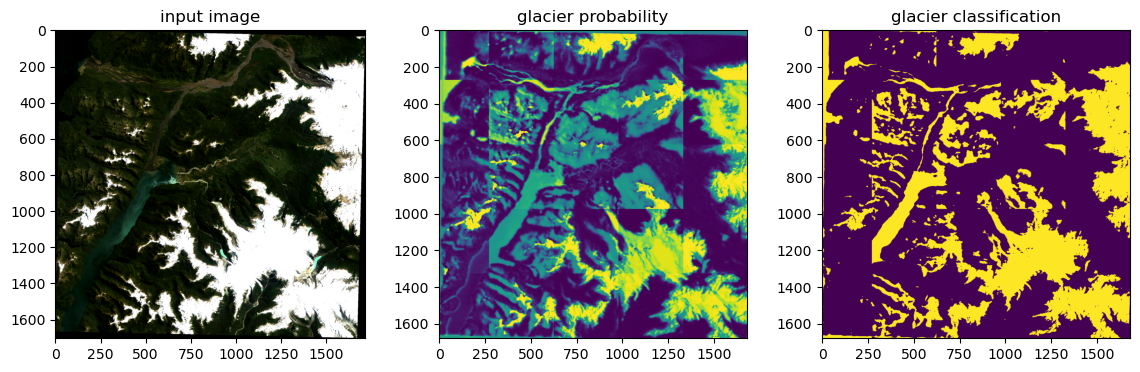

In [6]:
### show the results
imsShow([stacked_imgs, pro_pred, cla_pred], clip_list=[20, 2, 2], 
        img_name_list = ['input image', 'glacier probability', 'glacier classification'],
         figsize=(14, 4))


In [7]:
# ### write the result to path
# with rio.open(path_wat_pred, 'w', driver='GTiff',
#              height=cla_pred.shape[0],
#              width=cla_pred.shape[1],
#              count=1,
#              dtype=np.int8,
#              crs=imgs_meta['crs'],
#              transform=imgs_meta['transform']) as dst:
#     dst.write(cla_pred, 1)  


In [8]:
# ## load and show the image and the prediction map
# with rio.open(path_img) as img_src, \
#         rio.open(path_wat_pred) as pred_src,\
#         rio.open(path_dem) as dem_src:
#         img_arr = img_src.read().transpose(1, 2, 0)  # change to channel last format
#         pred_arr = pred_src.read(1)   # read the first band (the classification result)
#         dem_arr = dem_src.read(1)  # read the DEM band
# imsShow([img_arr, dem_arr, pred_arr], ['input image', 'dem', 'glacier prediction'], clip_list=[25, 2, 2], figsize=(10, 3))
